# Real Estate Price Prediction

Прежде всего импортируем все модули, которые будут использоваться.

In [1331]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/realestatepriceprediction/sample_submission.csv
/kaggle/input/realestatepriceprediction/train.csv
/kaggle/input/realestatepriceprediction/test.csv


In [1332]:
from matplotlib import pyplot as plt
import random
import seaborn as sns

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

from datetime import datetime

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [1333]:
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [1334]:
TRAIN_DATASET_PATH = '/kaggle/input/realestatepriceprediction/train.csv'
TEST_DATASET_PATH = '/kaggle/input/realestatepriceprediction/test.csv'

In [1335]:
df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [1336]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [1337]:
print('Строк в трейне:', df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


Изменим для удобства работы тип значений в столбце **DistrictId**.

In [1338]:
df['DistrictId'] = df['DistrictId'].astype(str)

# 1. EDA

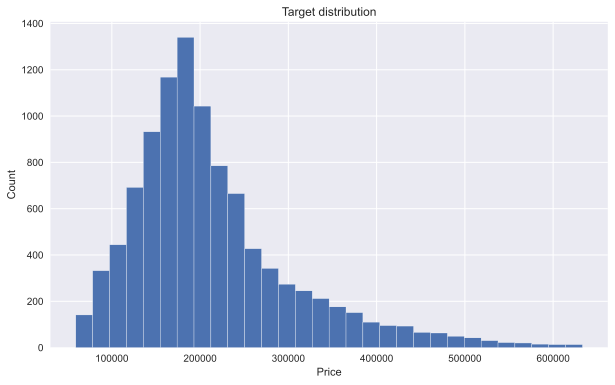

In [7]:
plt.style.use('seaborn')
plt.figure(figsize = (10, 6))

df['Price'].hist(bins=30, ec='white')
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Видно, что распределение целевой переменной имеет явный скос в правую сторону.

In [1340]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Видно, что переменные **Ecology_2, Ecology_3** и **Shops_2** являются номинативными. <br>
Для признака **Healthcare_1** отсутствует значение в почти половине случаев. На мой взгляд, наиболее правильным подходом будет исключение данного признака.

# 2. Обработка выбросов и пропусков

#### 2.1. Square, LifeSquare, KitchenSquare

Посмотрим внимательнее на признаки, описывающие площадь квартиры: **Square**, **LifeSquare** и **KitchenSquare**.

In [1341]:
df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,7887.000000,10000.000000
mean,56.315775,37.199645,6.273300
std,21.058732,86.241209,28.560917
min,1.136859,0.370619,0.000000
25%,41.774881,22.769832,1.000000
50%,52.513310,32.781260,6.000000
75%,65.900625,45.128803,9.000000
max,641.065193,7480.592129,2014.000000


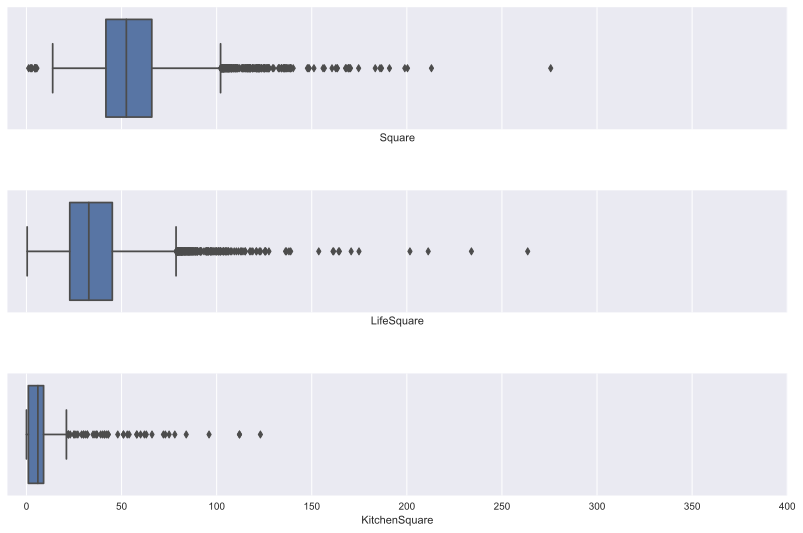

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
plt.setp(ax, xlim=(-10, 400))
ax1, ax2, ax3 = ax.flatten()

fig.set_size_inches(14, 9)
fig.subplots_adjust(wspace=0.5, hspace=0.5)


sns.boxplot(x=df['Square'], orient='h', ax=ax1)
sns.boxplot(x=df['LifeSquare'], orient='h', ax=ax2)
sns.boxplot(x=df['KitchenSquare'], orient='h', ax=ax3)
plt.show()

In [1343]:
condition = df['Square'] < df['LifeSquare']
df.loc[condition, ['Square', 'LifeSquare', 'KitchenSquare']].shape

(482, 3)

Здесь можно заметить следующие проблемы:
1. В столбце **LifeSquare** присутствуют пропущенные значения;
2. Для ***482*** наблюдений площадь квартиры меньше значения жилой площади;
3. Можно утверждать, что присутствуют выбросы, так как для всех признаков присутствуют значения сильно отклоняющиеся от ***25%*** и ***75%*** квантилей;
4. Минимальное значение в столбце **KitchenSquare** равно нулю. Это может с одной стороны указывать на ошибки при заполнении, с другой стороны это может указывать на квартиры студии, в которых кухня может считаться частью жилой площади. С другой стороны видно, что в ***25%*** наблюдений значение в столбце **KitchenSquare** меньше **1 кв. м**.

Для решения первых двух проблем создадим новый столбец **SquareNew**, который будет содержать максимум из величин в столбцах **Square** и **LifeSquare**.

In [1344]:
df['SquareNew'] = df[['Square', 'LifeSquare']].max(axis=1)
df[['Square', 'LifeSquare', 'KitchenSquare', 'SquareNew']].describe()

,Square,LifeSquare,KitchenSquare,SquareNew
count,10000.000000,7887.000000,10000.000000,10000.000000
mean,56.315775,37.199645,6.273300,57.223484
std,21.058732,86.241209,28.560917,77.309420
min,1.136859,0.370619,0.000000,2.377248
25%,41.774881,22.769832,1.000000,41.866858
50%,52.513310,32.781260,6.000000,52.633651
75%,65.900625,45.128803,9.000000,66.004634
max,641.065193,7480.592129,2014.000000,7480.592129


Для решения проблемы, обозначенной в третьем пункте, посчитаем количество выбросов. Будем считать такими значения, отклоняющиеся от ***25%*** и ***75%*** квартилей более чем на ***1.5*** межквартильных размаха.

In [1345]:
sq_75 = df['SquareNew'].quantile(.75)
sq_25 = df['SquareNew'].quantile(.25)
IQR = sq_75 - sq_25
condition = (df['SquareNew'] < sq_25 - 1.5 * IQR) | (df['SquareNew'] > sq_75 + 1.5 * IQR)
df[condition].shape[0]

243

Так как они составляют небольшую долю выборки, можем их удалить.

In [1346]:
df.drop(df[condition].index, inplace=True)

Кроме указанной ранее проблемы со значениями в столбце **KitchenSquare** присутствует вопрос корректности отношения площадей в определенных наблюдениях. Можно сказать, что она тоже связана с величинами в столбце **KitchenSquare**, так как в некоторых случаях разница между **Square** и **LifeSquare** меньше, чем **KitchenSquare**.

In [1347]:
condition = ~(df['Square'] < df['LifeSquare']) & (df['Square'] - df['LifeSquare'] < df['KitchenSquare'])
df.loc[condition, ['Square', 'LifeSquare', 'KitchenSquare']].head()

,Square,LifeSquare,KitchenSquare
3,53.352981,52.731512,9.0
48,47.080100,46.807989,12.0
69,64.929103,63.304605,10.0
129,65.102017,64.622603,1.0
136,92.400007,92.069236,10.0


#### 2.2. Rooms

Посмотрим на столбец с количеством комнат.

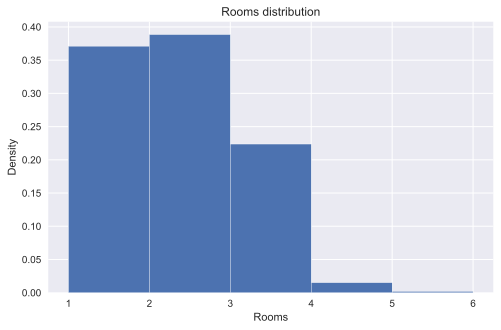

In [9]:
bins_list=[1,2,3,4,5,6]

plt.figure(figsize=(8,5))

plt.hist(df['Rooms'], density=True, bins=bins_list, ec='White')
plt.ylabel('Density')
plt.xlabel('Rooms')
plt.title('Rooms distribution')
plt.show()

In [1349]:
df['Rooms'].value_counts()

2.0     3869
1.0     3675
3.0     2098
4.0      101
0.0        5
5.0        5
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Видно, что есть небольшое количество выбросов. Заменим их на медианное значение.

In [1350]:
df.loc[(df['Rooms'] > 5) | (df['Rooms'] == 0), 'Rooms'] = df['Rooms'].median()

Добавим две новых номинативных переменных:
1. Переменная **Kitchen** будет отражать наличие или отсутствие кухни на основе представленных данных. Будем считать, что кухни нет, если значение ее площади менее **1 кв.м.** (как было указано выше, под этот критерий подпадает около 25% всех квартир).
2. Переменная **FlatType** будет показывать имеем ли мы дело с квартирой, в которой одна, две или больше комнат.

In [1351]:
df['Kitchen'] = 'No'
df.loc[df['KitchenSquare'] > 1, 'Kitchen'] = 'Yes'

In [1352]:
df.loc[df['Rooms'] == 1, 'FlatType'] = 'One room'
df.loc[df['Rooms'] == 2, 'FlatType'] = 'Two rooms'
df.loc[df['Rooms'] >= 3, 'FlatType'] = 'Three and more rooms'

#### 2.3. Floor, HouseFloor

Рассмотрим данные по этажности квартир.

In [1353]:
df[['Floor', 'HouseFloor']].describe()

,Floor,HouseFloor
count,9757.000000,9757.000000
mean,8.507226,12.615558
std,5.185754,6.651266
min,1.000000,0.000000
25%,4.000000,9.000000
50%,7.000000,13.000000
75%,12.000000,17.000000
max,42.000000,117.000000


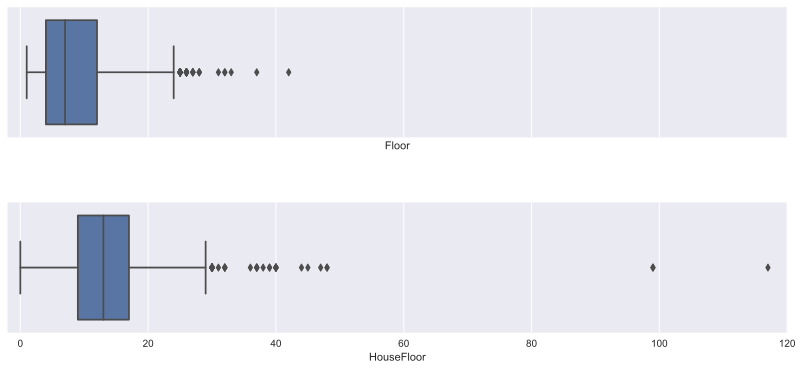

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
plt.setp(ax, xlim=(-2, 120))
ax1, ax2 = ax.flatten()

fig.set_size_inches(14, 6)
fig.subplots_adjust(wspace=0.5, hspace=0.5)


sns.boxplot(x=df['Floor'], orient='h', ax=ax1)
sns.boxplot(x=df['HouseFloor'], orient='h', ax=ax2)
plt.show()

Опять же можно говорить о наличии явно выраженных выбросов. Особенно заметны они в случае признака **HouseFloor**. Заменим значение этажности дома на медиану, когда оно превышает 60.

In [1355]:
condition = df['HouseFloor'] > 60
df.loc[condition, 'HouseFloor'] = df['HouseFloor'].median()
df[condition].shape[0]

3

In [1356]:
df[['Floor', 'HouseFloor']].describe()

,Floor,HouseFloor
count,9757.000000,9757.000000
mean,8.507226,12.587271
std,5.185754,6.449181
min,1.000000,0.000000
25%,4.000000,9.000000
50%,7.000000,13.000000
75%,12.000000,17.000000
max,42.000000,48.000000


In [1357]:
condition = (df['HouseFloor'] > 0) & (df['Floor'] > df['HouseFloor'])
df.loc[condition, ['Floor', 'HouseFloor']].head()

,Floor,HouseFloor
14,5,4.0
16,6,5.0
21,15,1.0
35,6,5.0
51,11,9.0


Можно заметить, что остаются две проблемы, связанные со значениями признаков **Floor** и **HouseFloor**:
1. В столбце **HouseFloor** присутствуют нулевые значения, на что указывает минимальное значение равное нулю;
2. Для некоторых ненулевых наблюдений **HouseFloor** меньше, чем **Floor**, что противоречит логике. Скорее всего, на мой взгляд, это связано с ошибкой при заполнении, то есть значения в столбцах перепутаны.

Начнем с решения второй проблемы. Создадим новые столбцы **HouseFloorNew** и **FloorNew** для отражения этажности дома и квартиры соответственно, а затем для ненулевых значений **HouseFloor** заполним их так, чтобы они не противоречили логике (поменяем значения в столбцах для этих случаев).

In [1358]:
df['HouseFloorNew'] = df['HouseFloor']
df['FloorNew'] = df['Floor']

Определим индексы интересующих нас наблюдений и произведем замены.

In [1359]:
condition = (df['HouseFloor'] > 0) & (df['Floor'] > df['HouseFloor'])
wrong_floor_index = df[condition].index
df.loc[wrong_floor_index, 'HouseFloorNew'], df.loc[wrong_floor_index, 'FloorNew'] = \
                    df.loc[wrong_floor_index, 'Floor'], df.loc[wrong_floor_index, 'HouseFloor']
df.loc[condition, ['Floor', 'HouseFloor', 'FloorNew', 'HouseFloorNew']].head()

,Floor,HouseFloor,FloorNew,HouseFloorNew
14,5,4.0,4.0,5.0
16,6,5.0,5.0,6.0
21,15,1.0,1.0,15.0
35,6,5.0,5.0,6.0
51,11,9.0,9.0,11.0


Остается первая проблема с нулевыми наблюдениями в столбце **HouseFloor**. Можно либо удалить эти наблюдения, либо постараться их заполнить.

In [1360]:
condition = df['HouseFloor'] == 0
df.loc[condition, ['HouseFloor', 'Floor']].head()

,HouseFloor,Floor
7,0.0,14
39,0.0,16
65,0.0,6
70,0.0,9
195,0.0,14


Для начала попробуем заменить эти значения медианой для соответствующего района.

In [1361]:
condition = df['HouseFloor'] == 0
zero_house_floor_index = df[condition].index
zero_house_floor_district_id = df.loc[condition, 'DistrictId'].unique()
dist_ids = pd.DataFrame(zero_house_floor_district_id, columns=['DistrictId'])
dist_median = df[['DistrictId','HouseFloor']].groupby(by='DistrictId', as_index=False).median()
dist_ids_median = pd.merge(dist_ids, dist_median, on='DistrictId')
df['HouseFloorOutlier'] = "No"
df.loc[zero_house_floor_index, 'HouseFloorOutlier'] = "Adjusted with median"
for el in zero_house_floor_index:
    hf = dist_ids_median.loc[dist_ids_median['DistrictId'] == df.loc[el, 'DistrictId'], 'HouseFloor'].values
    df.loc[el, 'HouseFloorNew'] = hf
df.loc[df['HouseFloor'] == 0, ['HouseFloorNew', 'FloorNew', 'HouseFloorOutlier']].head()

,HouseFloorNew,FloorNew,HouseFloorOutlier
7,16.0,14.0,Adjusted with median
39,17.0,16.0,Adjusted with median
65,12.0,6.0,Adjusted with median
70,12.0,9.0,Adjusted with median
195,9.0,14.0,Adjusted with median


Однако видно, что не во всех исправленных с помощью медианы случаях, выполняется логическое условие, что этаж квартиры должен быть меньше этажности дома.

In [1362]:
condition = (df['HouseFloorNew'] < df['FloorNew'])
df.loc[condition, 'HouseYear'].value_counts()

1977    44
2016     2
2015     2
Name: HouseYear, dtype: int64

В подавляющем большинстве случаев проблема касается домов, построенных в **1977** году. Используем в качестве апроксимации для исправления столбца **HouseFloorNew** максимальную высоту домов того же года.

In [1363]:
condition = (df['HouseFloorNew'] < df['FloorNew'])
df.loc[condition, 'HouseFloorOutlier'] = "Adjusted with max"
max_adj = df[condition].index
for el in max_adj:
    df.loc[el, 'HouseFloorNew'] = df.loc[df['HouseYear'] == df.loc[el, 'HouseYear'], 'HouseFloor'].max()
df[condition].shape

(48, 26)

#### 2.4. HouseYear

Посмотрим пристально на параметр, отвечающий за год постройки дома.

In [1364]:
df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
4493        2020
3357        2020
790         2020
          ...   
5053        1917
1380        1917
910         1914
5111        1912
9317        1910
Name: HouseYear, Length: 9757, dtype: int64

Видны два явных выброса, заменим их медианой.

In [1365]:
df.loc[df['HouseYear'] > 2020, 'HouseYear'] = df['HouseYear'].median()

#### 2.5. Предварительная обработка данных

Создадим класс, в котором поместим все необдходимые действия, которые нужно провести с данными перед использованием в модели.

In [1366]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        
    def fit(self, X):
        """Сохранение статистик"""
        self.medians = X.median()
        self.dist_median_housefloor = X[['DistrictId','HouseFloor']].groupby(by='DistrictId', as_index=False).median()
        self.year_median_housefloor = X[['HouseYear','HouseFloor']].groupby(by='HouseYear', as_index=False).max()
        
    def remove_outliers_squarenew(self, X):
        """Удаляем выбросы по признаку SquareNew"""
        sq_75 = X['SquareNew'].quantile(.75)
        sq_25 = X['SquareNew'].quantile(.25)
        IQR = sq_75 - sq_25
        condition = (X['SquareNew'] < sq_25 - 1.5 * IQR) | (X['SquareNew'] > sq_75 + 1.5 * IQR)
        shape = X[condition].shape[0]
        X.drop(X[condition].index, inplace=True)
        print(f'Удалено {shape} записей.\n')
        
        return X
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X.loc[(X['Rooms'] > 5) | (X['Rooms'] == 0), 'Rooms'] = self.medians['Rooms']
        
        # SquareNew
        X['SquareNew'] = X[['Square', 'LifeSquare']].max(axis=1)
        
        # HouseFloor, Floor
        condition1 = X['HouseFloor'] > 60
        number_of_values = X[condition1].shape[0]
        X.loc[condition1, 'HouseFloor'] = self.medians['HouseFloor']
        print(f'Заменено {number_of_values} значений в столбце HouseFloor медианой.')
        
        X['HouseFloorNew'] = X['HouseFloor']
        X['FloorNew'] = X['Floor']

        condition2 = (X['HouseFloor'] > 0) & (X['Floor'] > X['HouseFloor'])
        wrong_floor_index = X[condition2].index
        X.loc[wrong_floor_index, 'HouseFloorNew'], X.loc[wrong_floor_index, 'FloorNew'] = \
                    X.loc[wrong_floor_index, 'Floor'], X.loc[wrong_floor_index, 'HouseFloor']
        
        
        condition3 = X['HouseFloor'] == 0
        number_of_values = X[condition3].shape[0]
        zero_house_floor_index = X[condition3].index
        zero_house_floor_district_id = X.loc[condition3, 'DistrictId'].unique()
        dist_ids = pd.DataFrame(zero_house_floor_district_id, columns=['DistrictId'])        
        dist_ids_median = pd.merge(dist_ids, self.dist_median_housefloor, on='DistrictId')
        X['HouseFloorOutlier'] = "No"
        X.loc[zero_house_floor_index, 'HouseFloorOutlier'] = "Adjusted with median"
        for el in zero_house_floor_index:
            hf = dist_ids_median.loc[dist_ids_median['DistrictId'] == X.loc[el, 'DistrictId'], 'HouseFloor'].values
            X.loc[el, 'HouseFloorNew'] = hf
        print(f'Заменено {number_of_values} значений в столбце HouseFloorNew медианой для данного района.')
        
        condition4 = (X['HouseFloorNew'] < X['FloorNew'])
        number_of_values = X[condition4].shape[0]
        incorrect_house_floor_index = X[condition4].index
        incorrect_house_floor_index_id = X.loc[condition4, 'HouseYear'].unique()
        year_ids = pd.DataFrame(incorrect_house_floor_index_id, columns=['HouseYear'])        
        year_ids_median = pd.merge(year_ids, self.year_median_housefloor, on='HouseYear')
        X.loc[condition4, 'HouseFloorOutlier'] = "Adjusted with max"
        for el in incorrect_house_floor_index:
            hf = year_ids_median.loc[year_ids_median['HouseYear'] == X.loc[el, 'HouseYear'], 'HouseFloor'].values
            X.loc[el, 'HouseFloorNew'] = hf
        print(f'Заменено {number_of_values} значений в столбце HouseFloorNew максимальным для данного года постройки.')
        
        
        
        # Исправляем выбросы в столбце HouseYear
        current_year = datetime.now().year     
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        print('\n')
        
        X.fillna(self.medians, inplace=True)
        
        return X

# 3. Построение новых признаков

#### 3.1. Работа с существующими номинативными переменными

Посмотрим на номинативные переменные, которые есть в исходном наборе данных: **Ecology_2**, **Ecology_3**, **Shops_2**.

In [1367]:
df['Ecology_2'].value_counts()

B    9660
A      97
Name: Ecology_2, dtype: int64

In [1368]:
df['Ecology_3'].value_counts()

B    9485
A     272
Name: Ecology_3, dtype: int64

In [1369]:
df['Shops_2'].value_counts()

B    8963
A     794
Name: Shops_2, dtype: int64

Во всех случаях возможны только два значения, поэтому заменим их на 1 и 0.

In [1370]:
binary_to_numbers = {'A': 0, 'B': 1}

df['Ecology_2'] = df['Ecology_2'].replace(binary_to_numbers)
df['Ecology_3'] = df['Ecology_3'].replace(binary_to_numbers)
df['Shops_2'] = df['Shops_2'].replace(binary_to_numbers)

Аналогичным образом обстоит ситуацию с колонкой **Kitchen**.

In [1371]:
df['Kitchen'].value_counts()

Yes    6716
No     3041
Name: Kitchen, dtype: int64

In [1372]:
binary_to_numbers = {'Yes': 0, 'No': 1}

df['Kitchen'] = df['Kitchen'].replace(binary_to_numbers)

#### 3.2. Добавление новых признаков

Добавим признак **HouseType**, который будет описывать тип нашего дома в зависимости от количества этажей.

In [1373]:
df['HouseType'] = 'Under 5 floors'
df.loc[(df['HouseFloorNew'] > 5) & (df['HouseFloorNew'] < 10), 'HouseType'] = 'Under 10 floors'
df.loc[(df['HouseFloorNew'] > 10) & (df['HouseFloorNew'] < 21), 'HouseType'] = 'Under 20 floors'
df.loc[(df['HouseFloorNew'] >= 21), 'HouseType'] = 'Skyscraper'

Далее введем признак **Floor_Category**, который будет учитывать, находится ли квартира на первом или последнем этаже.

In [1374]:
df['Floor_Category'] = 'Middle'
df.loc[(df['FloorNew'] == df['HouseFloorNew']) & (df['HouseFloorNew'] == 1), 'Floor_Category'] = 'Own house'
df.loc[(df['FloorNew'] == df['HouseFloorNew']) & (df['HouseFloorNew'] != 1), 'Floor_Category'] = 'Roof'
df.loc[(df['FloorNew'] == 1) & (df['HouseFloorNew'] != 1), 'Floor_Category'] = 'Basement'

А также признак **FloorRel**, который показывает отношение этажа квартиры к общей высоте дома.

In [1375]:
df['FloorRel'] = df['FloorNew'] / df['HouseFloorNew']

Еще введем номинативный признак, который будет указывать нарушается ли логическое соотношение между величинами площади: **KitchenSquare**, **LifeSquare** и **Square**.

In [1376]:
df['StrangeSquare'] = 'No'
df.loc[df['LifeSquare'] + df['KitchenSquare'] > df['Square'], 'StrangeSquare'] = 'Yes'

#### 3.3. Генерация новых признаков в наборе данных

Вынесем работу с модификацией списка признаков в отдельный класс для удобства дальнейшего анализа.

In [1377]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.yesno_to_numbers = None
        self.binary_to_numbers = None
        
    def fit(self, X, y=None):
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        self.yesno_to_numbers = {'Yes': 0, 'No': 1}
            
        
    def transform(self, X):
        
        # Kitchen
        X['Kitchen'] = 'No'
        X.loc[X['KitchenSquare'] > 1, 'Kitchen'] = 'Yes'
        
        # FlatType
        X.loc[X['Rooms'] == 1, 'FlatType'] = 'One room'
        X.loc[X['Rooms'] == 2, 'FlatType'] = 'Two rooms'
        X.loc[X['Rooms'] >= 3, 'FlatType'] = 'Three and more rooms'
        
        # StrangeSquare
        X['StrangeSquare'] = 'No'
        X.loc[X['LifeSquare'] + X['KitchenSquare'] > X['Square'], 'StrangeSquare'] = 'Yes'
        
        # HouseType
        X['HouseType'] = 'Under 5 floors'
        X.loc[(X['HouseFloorNew'] > 5) & (X['HouseFloorNew'] < 10), 'HouseType'] = 'Under 10 floors'
        X.loc[(X['HouseFloorNew'] > 10) & (X['HouseFloorNew'] < 21), 'HouseType'] = 'Under 20 floors'
        X.loc[(X['HouseFloorNew'] >= 21), 'HouseType'] = 'Skyscraper'

        # Floor_Category
        X['Floor_Category'] = 'Middle'
        X.loc[(X['FloorNew'] == X['HouseFloorNew']) & (X['HouseFloorNew'] == 1), 'Floor_Category'] = 'Own house'
        X.loc[(X['FloorNew'] == X['HouseFloorNew']) & (X['HouseFloorNew'] != 1), 'Floor_Category'] = 'Roof'
        X.loc[(X['FloorNew'] == 1) & (X['HouseFloorNew'] != 1), 'Floor_Category'] = 'Basement'
        
        # FloorRel
        
        X['FloorRel'] = X['FloorNew'] / X['HouseFloorNew']

       
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers) 
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        X['Kitchen'] = X['Kitchen'].map(self.yesno_to_numbers)
        X['StrangeSquare'] = X['StrangeSquare'].map(self.yesno_to_numbers)
        
        
        X = pd.get_dummies(X)
        
        return X
            

# 4. Отбор признаков

In [1378]:
df.columns.to_list()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'SquareNew',
 'Kitchen',
 'FlatType',
 'HouseFloorNew',
 'FloorNew',
 'HouseFloorOutlier',
 'HouseType',
 'Floor_Category',
 'FloorRel',
 'StrangeSquare']

In [1379]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9757 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 9757 non-null   int64  
 1   DistrictId         9757 non-null   object 
 2   Rooms              9757 non-null   float64
 3   Square             9757 non-null   float64
 4   LifeSquare         7710 non-null   float64
 5   KitchenSquare      9757 non-null   float64
 6   Floor              9757 non-null   int64  
 7   HouseFloor         9757 non-null   float64
 8   HouseYear          9757 non-null   int64  
 9   Ecology_1          9757 non-null   float64
 10  Ecology_2          9757 non-null   int64  
 11  Ecology_3          9757 non-null   int64  
 12  Social_1           9757 non-null   int64  
 13  Social_2           9757 non-null   int64  
 14  Social_3           9757 non-null   int64  
 15  Healthcare_1       5086 non-null   float64
 16  Helthcare_2        9757 

In [1380]:
features_to_remove = ['Id', 'DistrictId', 'Healthcare_1', 'Square', 'HouseType_Under 5 floors', 'HouseType_Under 10 floors'
                      ,'HouseType_Under 20 floors', 'HouseType_Skyscraper', 'HouseFloorOutlier_Adjusted with median'
                      ,'HouseFloorOutlier_Adjusted with max', 'HouseFloorOutlier_No' , 'Kitchen', 'FlatType_One room'
                      ,'FlatType_Two rooms', 'FlatType_Three and more rooms', 'StrangeSquare', 'Floor', 'HouseFloor', 'LifeSquare'
                      , 'Ecology_2', 'FloorRel'
                      ,'Floor_Category_Own house','Floor_Category_Middle', 'Floor_Category_Roof', 'Floor_Category_Basement'
                     ]
target_name = 'Price'

# 5. Разбиение на выборки для обучения и теста

Загружаем данные и разбиваем их на тренировочный и валидационный наборы.

In [1381]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [1382]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

Предварительная обработка данных:

In [1383]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

print('Тренировочный набор данных: ')
X_train = preprocessor.transform(X_train)

print('Валидационный набор данных: ')
X_valid = preprocessor.transform(X_valid)

print('Тестовый набор данных: ')
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

Тренировочный набор данных: 
Заменено 2 значений в столбце HouseFloor медианой.
Заменено 177 значений в столбце HouseFloorNew медианой для данного района.
Заменено 33 значений в столбце HouseFloorNew максимальным для данного года постройки.


Валидационный набор данных: 
Заменено 1 значений в столбце HouseFloor медианой.
Заменено 92 значений в столбце HouseFloorNew медианой для данного района.
Заменено 19 значений в столбце HouseFloorNew максимальным для данного года постройки.


Тестовый набор данных: 
Заменено 1 значений в столбце HouseFloor медианой.
Заменено 131 значений в столбце HouseFloorNew медианой для данного района.
Заменено 32 значений в столбце HouseFloorNew максимальным для данного года постройки.




((6700, 23), (3300, 23), (5000, 23))

Проведем работу с признаками.

In [1384]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 39), (3300, 39), (5000, 39))

Удалим лишние признаки.

In [1385]:
X_train.drop(columns=features_to_remove, inplace=True)
X_valid.drop(columns=features_to_remove, inplace=True)
test_df.drop(columns=features_to_remove, inplace=True)

 Проверим данные на наличие пропущенных значений.

In [1386]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

# 6. Построение модели

#### 6.1. Обучение

In [1387]:
model1 = RandomForestRegressor(n_estimators=350, max_depth=14, max_features=6, random_state=42)
model1.fit(X_train, y_train)

RandomForestRegressor(max_depth=14, max_features=6, n_estimators=350,
                      random_state=42)

In [1388]:
model2 = RandomForestRegressor(n_estimators=500, max_depth=17, max_features=8, random_state=42)

In [1389]:
model3 = XGBRegressor(objective ='reg:squarederror', n_estimators=1000, learning_rate=0.05)
model3.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)], verbose=False)

XGBRegressor(learning_rate=0.05, n_estimators=1000,
             objective='reg:squarederror')

In [1390]:
model4 = VotingRegressor(estimators=[('xg', model3), ('rf', model1)])
model4.fit(X_train, y_train)

VotingRegressor(estimators=[('xg',
                             XGBRegressor(learning_rate=0.05, n_estimators=1000,
                                          objective='reg:squarederror')),
                            ('rf',
                             RandomForestRegressor(max_depth=14, max_features=6,
                                                   n_estimators=350,
                                                   random_state=42))])

#### 6.2. Оценка модели

In [1391]:
y_pred_rfr = model1.predict(X_valid)
r2(y_valid, y_pred_rfr)

0.728264403025555

In [1392]:
y_pred_train = model1.predict(X_train)
r2(y_train, y_pred_train)

0.9293165365270223

Судя по всему присутствует проблема переобучения.

In [1393]:
fi = pd.DataFrame(model1.feature_importances_, index=X_train.columns, columns=['importance'])
fi.sort_values(by='importance', ascending=False)

,importance
SquareNew,0.339490
Rooms,0.141287
Social_1,0.092218
Social_2,0.089134
Social_3,0.073130
KitchenSquare,0.050154
Ecology_1,0.048677
HouseYear,0.047342
HouseFloorNew,0.041643
FloorNew,0.028149


In [1394]:
#cv_score = cross_val_score(model1, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
#cv_score.mean()

In [1395]:
preds_valid = model3.predict(X_valid)
r2(y_valid, preds_valid)

0.7249761165013119

In [1396]:
fi = pd.DataFrame(model3.feature_importances_, index=X_train.columns, columns=['importance'])
fi.sort_values(by='importance', ascending=False)

,importance
SquareNew,0.218970
Rooms,0.180689
Social_1,0.142398
Social_3,0.122783
Social_2,0.087406
Ecology_1,0.057141
HouseFloorNew,0.031889
HouseYear,0.030619
KitchenSquare,0.030579
FloorNew,0.022116


In [1397]:
preds_train = model3.predict(X_train)
r2(y_train, preds_train)

0.7972189616271235

В данном случае похоже есть переобучение, но не такое значительное, как в первой модели.

In [1398]:
y_preds=model4.predict(X_valid)
r2(y_valid, y_preds)

0.741748819462915

# 7. Прогнозирование на тестовом наборе данных

In [1399]:
submit = pd.read_csv('../input/realestatepriceprediction/sample_submission.csv')
submit.head()

,Id,Price
0,725,200000.0
1,15856,200000.0
2,5480,200000.0
3,15664,200000.0
4,14275,200000.0


In [1400]:
predictions = model4.predict(test_df)
predictions

array([159647.80997938, 179853.80470902, 224631.89411294, ...,
       346454.52819255, 203082.38128264, 177143.28844663])

In [1401]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,725,159647.809979
1,15856,179853.804709
2,5480,224631.894113
3,15664,363743.287313
4,14275,138104.523745


In [1402]:
submit.to_csv('rf_submit.csv', index=False)